# IBM Applied Data Science Capstone Project

### Segmenting and Clustering Neighborhoods in Seoul
***
### 1. Import libraries

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
# import the library we use to open URLs
import urllib.request

import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge geocoder --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

### 2. Scrap data from Wikipedia page into a DataFrame

In [2]:
# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/List_of_districts_of_Seoul"

In [3]:
#open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

In [4]:
#parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")

In [5]:
#use the 'find_all' function to bring back all instances of the 'table' tag in the HTML and store in 'all_tables' variable
all_tables=soup.find_all("table")

In [6]:
right_table=soup.find('table', class_='wikitable sortable')

In [7]:
neighborhoodList=[]

for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==4:
        neighborhoodList.append(cells[0].find(text=True))

In [8]:

# create a new DataFrame from the list
df_seoul = pd.DataFrame({"Neighborhood": neighborhoodList,"Latitude": 0, "Longitude": 0})

df_seoul.shape

(26, 3)

### 3. Load the coordinates from geocoder API

In [9]:
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Seoul, Korea'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [10]:
coords=[]
for neighborhood in df_seoul["Neighborhood"].tolist():
    coords.extend([get_latlng(neighborhood)])

In [11]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [12]:
df_seoul.loc[:,['Latitude','Longitude']] = df_coords.loc[:,['Latitude','Longitude']]

In [13]:
df_seoul.shape

(26, 3)

### 4. Visualize the neighborhoods in Toronto

#### Add latitude and longitude

In [14]:
address = 'Seoul, Korea'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seoul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seoul are 37.5666791, 126.9782914.


Map of Toronto

In [15]:
map_seoul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df_seoul['Latitude'], df_seoul['Longitude'], df_seoul['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seoul)  
    
map_seoul

### 5. Import data from Foursquare

#### Setting up the credentials

In [16]:
CLIENT_ID = 'WPJPWFOYKKNUOZQHEIEZI12L4NUHZNZB5JQXCCNWBT3GFI2Z' # your Foursquare ID
CLIENT_SECRET = 'UC4D1ZJO5I0Q5RO43OFPG03WTK5LIULKMJFGFATE1D2TTULJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WPJPWFOYKKNUOZQHEIEZI12L4NUHZNZB5JQXCCNWBT3GFI2Z
CLIENT_SECRET:UC4D1ZJO5I0Q5RO43OFPG03WTK5LIULKMJFGFATE1D2TTULJ


#### Create and send the GET request

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
seoul_venues = getNearbyVenues(names=df_seoul['Neighborhood'],
                                   latitudes=df_seoul['Latitude'],
                                   longitudes=df_seoul['Longitude']
                                  )


Dobong-gu
Dongdaemun-gu
Dongjak-gu
Eunpyeong-gu
Gangbuk-gu
Gangdong-gu
Gangnam-gu
Gangseo-gu
Geumcheon-gu
Guro-gu
Gwanak-gu
Gwangjin-gu
Jongno-gu
Jung-gu
Jungnang-gu
Mapo-gu
Nowon-gu
Seocho-gu
Seodaemun-gu
Seongbuk-gu
Seongdong-gu
Songpa-gu
Yangcheon-gu
Yeongdeungpo-gu
Yongsan-gu
Seoul


In [19]:
seoul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dobong-gu,37.65066,127.03011,Dooly Museum (둘리뮤지엄),37.652075,127.027749,Museum
1,Dobong-gu,37.65066,127.03011,Starbucks (스타벅스),37.648425,127.034681,Coffee Shop
2,Dobong-gu,37.65066,127.03011,쌍문근린공원,37.653162,127.028883,Park
3,Dobong-gu,37.65066,127.03011,路地라멘,37.646937,127.032239,Ramen Restaurant
4,Dobong-gu,37.65066,127.03011,채랑,37.647300,127.033502,Korean Restaurant


### 6. Preproccessing

#### One hot encoding and grouping by neighborhoods

In [20]:
# one hot encoding
seoul_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")

In [21]:
seoul_onehot.head()

,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Food,French Restaurant,Fried Chicken Joint,Garden,Gastropub,Gift Shop,Grocery Store,Gukbap Restaurant,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mountain,Movie Theater,Multiplex,Museum,Noodle House,Office,Optical Shop,Outlet Store,Palace,Park,Pedestrian Plaza,Perfume Shop,Photography Studio,Pizza Place,Plaza,Pub,Public Bathroom,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Sake Bar,Samgyetang Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Snack Place,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,Warehouse Store,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
seoul_onehot['Neighborhood'] = seoul_venues['Neighborhood'] 

In [23]:
# move neighborhood column to the first column
fixed_columns = [seoul_onehot.columns[-1]] + list(seoul_onehot.columns[:-1])
seoul_onehot = seoul_onehot[fixed_columns]

seoul_onehot.head()

,Neighborhood,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Food,French Restaurant,Fried Chicken Joint,Garden,Gastropub,Gift Shop,Grocery Store,Gukbap Restaurant,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mountain,Movie Theater,Multiplex,Museum,Noodle House,Office,Optical Shop,Outlet Store,Palace,Park,Pedestrian Plaza,Perfume Shop,Photography Studio,Pizza Place,Plaza,Pub,Public Bathroom,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Sake Bar,Samgyetang Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Snack Place,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,Warehouse Store,Wine Bar
0,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
seoul_grouped = seoul_onehot.groupby('Neighborhood').mean().reset_index()

### 7. Clustering

#### Show top 10 common venues in each venue

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [26]:
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

In [27]:
neighborhoods_venues_sorted['Neighborhood'] = seoul_grouped['Neighborhood']

In [28]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong-gu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Dongdaemun-gu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dongjak-gu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Eunpyeong-gu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gangbuk-gu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seoul_grouped['Neighborhood']

for ind in np.arange(seoul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong-gu,Ramen Restaurant,Coffee Shop,Park,Korean Restaurant,Museum,Fast Food Restaurant,Department Store,Dessert Shop,Dive Bar,Dog Run
1,Dongdaemun-gu,Coffee Shop,Fast Food Restaurant,Hotel,Noodle House,Japanese Restaurant,Bakery,Toy / Game Store,Supermarket,Duty-free Shop,Farmers Market
2,Dongjak-gu,Coffee Shop,Dumpling Restaurant,Korean Restaurant,Bakery,Bunsik Restaurant,Asian Restaurant,Ice Cream Shop,Dog Run,Dive Bar,Donut Shop
3,Eunpyeong-gu,Bakery,Bed & Breakfast,Museum,Fast Food Restaurant,Metro Station,Buffet,Hostel,Dumpling Restaurant,Donut Shop,Duty-free Shop
4,Gangbuk-gu,Bus Stop,Udon Restaurant,Donut Shop,Bakery,Brewery,Korean Restaurant,Wine Bar,Food,Fast Food Restaurant,Farmers Market


#### Find centroids with K-means

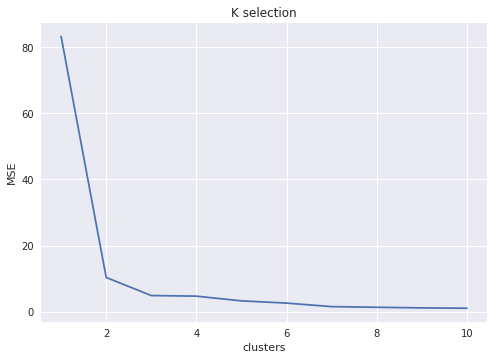

In [47]:
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
seoul_grouped_clustering = seoul_grouped.drop('Neighborhood', 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n

    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(seoul_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

#### Number of 5 clusters are chosen based on above elbow graph 

In [49]:
# set number of clusters
kclusters = 5

seoul_grouped_clustering = seoul_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(seoul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 0, 2, 2, 1, 0, 4, 4, 1], dtype=int32)

In [50]:
kmeans.labels_

array([4, 1, 0, 2, 2, 1, 0, 4, 4, 1, 4, 4, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0,
       0, 1, 0, 0], dtype=int32)

#### add clustering labels

In [52]:
# add clustering labels
#neighborhoods_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

### 8. Display clusters in maps

In [53]:
seoul_merged = df_seoul

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seoul_merged = seoul_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how='inner')

#toronto_merged.head() # check the last columns!

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['Neighborhood'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
seoul_grouped['Cluster'] = pd.DataFrame(kmeans.labels_)

### 9. Data Visualization

In [56]:
seoul_grouped_cluster = seoul_grouped.drop('Neighborhood',1).groupby('Cluster').mean().reset_index()

In [57]:
seoul_grouped_cluster

,Cluster,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Food,French Restaurant,Fried Chicken Joint,Garden,Gastropub,Gift Shop,Grocery Store,Gukbap Restaurant,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mountain,Movie Theater,Multiplex,Museum,Noodle House,Office,Optical Shop,Outlet Store,Palace,Park,Pedestrian Plaza,Perfume Shop,Photography Studio,Pizza Place,Plaza,Pub,Public Bathroom,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Sake Bar,Samgyetang Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Snack Place,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,Warehouse Store,Wine Bar
0,0,0.005577,0.003077,0.002308,0.011346,0.043391,0.001731,0.055058,0.000962,0.0000,0.001923,0.000769,0.004049,0.006264,0.003269,0.004049,0.004286,0.000000,0.008892,0.002308,0.038095,0.007995,0.005128,0.006073,0.052002,0.016218,0.002308,0.000962,0.002692,0.136227,0.005917,0.000962,0.00,0.000000,0.00989,0.003159,0.000769,0.017537,0.015395,0.000962,0.006044,0.00,0.009966,0.015339,0.016154,0.009104,0.012337,0.005128,0.000000,0.004478,0.000962,0.002500,0.027255,0.000769,0.004615,0.004286,0.006879,0.006923,0.001538,0.044397,0.001538,0.000769,0.000962,0.019231,0.020458,0.000962,0.014799,0.004049,0.000769,0.081743,0.003077,0.005972,0.0000,0.001731,0.002198,0.004049,0.002885,0.000962,0.000769,0.023399,0.000962,0.000769,0.00,0.000769,0.026027,0.000769,0.000769,0.000769,0.004698,0.009873,0.0025,0.002747,0.002024,0.000769,0.002198,0.006246,0.006933,0.000769,0.002692,0.010312,0.003846,0.006145,0.003929,0.004945,0.000769,0.000962,0.000000,0.000769,0.00,0.006832,0.00501,0.009167,0.005385,0.002794,0.000769,0.000962,0.002024,0.000962,0.000962,0.000962,0.000962,0.000769,0.005917,0.002024
1,1,0.000000,0.000000,0.000000,0.000000,0.013333,0.000000,0.083333,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026667,0.000000,0.000000,0.000000,0.013333,0.193333,0.000000,0.000000,0.05,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.026667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.013333,0.000000,0.000000,0.0000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.07000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.208333,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,

In [58]:
idx=[]
for i in range(5):
    temp = seoul_grouped_cluster[seoul_grouped_cluster['Cluster'] == i].drop('Cluster',1).T.reset_index()
    temp.columns = ['cluster','mean']
    idx.extend(list(temp.sort_values('mean',ascending=False).head(5).index))

In [59]:
temp_df=seoul_grouped_cluster[seoul_grouped_cluster.columns[np.asarray(list(set(idx)))+1]]

In [60]:
temp_df

,Department Store,Korean Restaurant,Donut Shop,Bakery,Fast Food Restaurant,Noodle House,Brewery,Buffet,Burger Joint,Bus Stop,Café,Hotel,Pizza Place,Ice Cream Shop,Ramen Restaurant,Coffee Shop
0,0.000000,0.081743,0.017537,0.055058,0.015339,0.023399,0.000000,0.002308,0.007995,0.006073,0.052002,0.006923,0.004698,0.044397,0.002024,0.136227
1,0.000000,0.013333,0.000000,0.083333,0.130000,0.070000,0.000000,0.000000,0.000000,0.000000,0.026667,0.120000,0.000000,0.026667,0.000000,0.193333
2,0.000000,0.083333,0.083333,0.208333,0.062500,0.000000,0.083333,0.062500,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857
4,0.000000,0.316667,0.016667,0.060000,0.010000,0.000000,0.000000,0.000000,0.000000,0.033333,0.093333,0.000000,0.000000,0.016667,0.040000,0.083333


In [61]:
table = pd.DataFrame(data = temp_df.values, index = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Cluster 5'], columns=temp_df.columns)

In [62]:
table=table.transpose()

#### Bar Chart

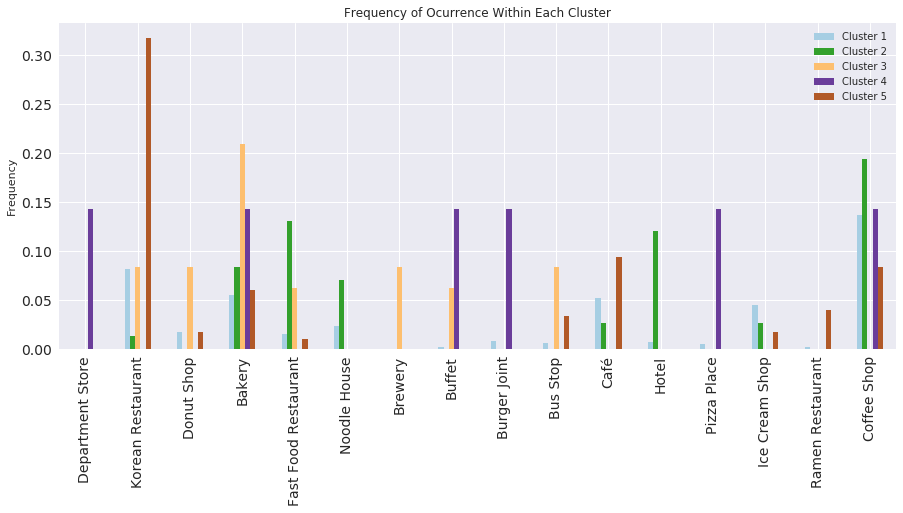

In [63]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()